In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import nibabel as nib
from skimage.transform import resize
from scipy.ndimage import rotate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, ReLU, MaxPooling2D,
                                     Conv2DTranspose, GlobalAveragePooling2D, Dense, Multiply,
                                     Add, concatenate, LayerNormalization, Reshape, Lambda)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K
from sklearn.model_selection import KFold, train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle

In [ ]:
# Configuration
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 1
BATCH_SIZE = 8
EPOCHS = 100
INIT_LR = 1e-4
N_FOLDS = 3
SEED = 42
DATA_PATH = "/content/drive/MyDrive/database_nifti"  # Update this with the actual dataset path

# Metrics
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def iou_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def average_precision(y_true, y_pred, thresholds=tf.constant(np.arange(0.0, 1.1, 0.1))):
    precisions = []
    for threshold in thresholds:
        y_pred_thresholded = tf.cast(y_pred > threshold, tf.float32)
        tp = tf.reduce_sum(y_true * y_pred_thresholded)
        fp = tf.reduce_sum((1 - y_true) * y_pred_thresholded)
        precision = tp / (tp + fp + K.epsilon())
        precisions.append(precision)
    return tf.reduce_mean(tf.stack(precisions))

In [ ]:
# Preprocessing
def load_nifti_image(file_path):
    img = nib.load(file_path)
    return np.squeeze(img.get_fdata())

def preprocess_patient_with_rotation(patient_folder, rotation_angles=[0, 90, 180, 270]):
    images = []
    masks_endo = []
    masks_epi = []
    masks_la = []

    views = ['2CH', '4CH']
    time_points = ['ED', 'ES']

    for view in views:
        for tp in time_points:
            base_name = os.path.basename(patient_folder)
            img_path = f"{patient_folder}/{base_name}_{view}_{tp}.nii.gz"
            gt_path = f"{patient_folder}/{base_name}_{view}_{tp}_gt.nii.gz"

            if not os.path.exists(img_path) or not os.path.exists(gt_path):
                continue

            try:
                img = load_nifti_image(img_path)
                gt = load_nifti_image(gt_path)

                img_resized = resize(img, (IMG_HEIGHT, IMG_WIDTH), preserve_range=True, anti_aliasing=True)
                gt_resized = resize(gt, (IMG_HEIGHT, IMG_WIDTH), preserve_range=True, anti_aliasing=False)

                img_resized = (img_resized - img_resized.min()) / (img_resized.max() - img_resized.min())

                mask_endo = (gt_resized == 1).astype(np.float32)
                mask_epi = (gt_resized == 2).astype(np.float32)
                mask_la = (gt_resized == 3).astype(np.float32)

                for angle in rotation_angles:
                    rotated_img = rotate(img_resized, angle, reshape=False, mode='reflect')
                    rotated_mask_endo = rotate(mask_endo, angle, reshape=False, mode='reflect')
                    rotated_mask_epi = rotate(mask_epi, angle, reshape=False, mode='reflect')
                    rotated_mask_la = rotate(mask_la, angle, reshape=False, mode='reflect')

                    images.append(rotated_img[..., np.newaxis])
                    masks_endo.append(rotated_mask_endo[..., np.newaxis])
                    masks_epi.append(rotated_mask_epi[..., np.newaxis])
                    masks_la.append(rotated_mask_la[..., np.newaxis])

            except Exception as e:
                print(f"Error processing {base_name}: {e}")
                continue

    if images:
        return np.array(images), np.array(masks_endo), np.array(masks_epi), np.array(masks_la)
    else:
        return np.array([]), np.array([]), np.array([]), np.array([])

def load_dataset(base_path):
    patient_folders = sorted([
        os.path.join(base_path, f)
        for f in os.listdir(base_path)
        if f.startswith('patient') and os.path.isdir(os.path.join(base_path, f))
    ])

    all_images = []
    all_masks_endo = []
    all_masks_epi = []
    all_masks_la = []

    for patient_folder in tqdm(patient_folders, desc="Loading patients"):
        images, masks_endo, masks_epi, masks_la = preprocess_patient_with_rotation(patient_folder)

        if images.size > 0:
            all_images.append(images)
            all_masks_endo.append(masks_endo)
            all_masks_epi.append(masks_epi)
            all_masks_la.append(masks_la)

    if not all_images:
        raise ValueError("No valid image data found in any patient folder!")

    return (np.concatenate(all_images, axis=0),
            np.concatenate(all_masks_endo, axis=0),
            np.concatenate(all_masks_epi, axis=0),
            np.concatenate(all_masks_la, axis=0))

In [ ]:

# Mamba-based TransUNet Model
def mamba_block(x, hidden_dim, ssm_dim, dropout_rate=0.1):
    """Implements a simplified Mamba block for 2D feature maps."""
    batch, height, width, channels = K.int_shape(x)

    # 1. Depthwise convolution for local feature mixing
    x_res = x
    x = LayerNormalization()(x)
    x = Conv2D(channels, kernel_size=3, padding='same', groups=channels)(x)

    # 2. Project to hidden dimension
    x = Conv2D(hidden_dim, kernel_size=1)(x)
    x = ReLU()(x)

    # 3. Simplified SSM (State Space Model) path
    # Reshape to sequence for SSM processing
    x_reshaped = Reshape((height * width, hidden_dim))(x)

    # Simplified SSM implementation (using dense layers as approximation)
    ssm = Dense(ssm_dim, activation='swish')(x_reshaped)
    ssm = Dense(hidden_dim)(ssm)

    # Residual connection
    ssm = Dense(hidden_dim)(x_reshaped) + ssm

    # Reshape back to spatial dimensions
    x_ssm = Reshape((height, width, hidden_dim))(ssm)

    # 4. Project back to channel dimension
    x_out = Conv2D(channels, kernel_size=1)(x_ssm)

    # Add dropout and residual
    x_out = tf.keras.layers.Dropout(dropout_rate)(x_out)
    x_out = x_res + x_out

    return x_out

def transunet_mamba(input_size=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    """TransUNet architecture with Mamba blocks in the encoder."""
    inputs = Input(input_size)

    # Initial convolution to project to higher dimension
    x = Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Encoder path with Mamba blocks
    # Level 1
    x1 = mamba_block(x, hidden_dim=128, ssm_dim=64)
    x1 = mamba_block(x1, hidden_dim=128, ssm_dim=64)
    p1 = MaxPooling2D(pool_size=(2, 2))(x1)

    # Level 2
    x2 = mamba_block(p1, hidden_dim=256, ssm_dim=128)
    x2 = mamba_block(x2, hidden_dim=256, ssm_dim=128)
    p2 = MaxPooling2D(pool_size=(2, 2))(x2)

    # Level 3
    x3 = mamba_block(p2, hidden_dim=512, ssm_dim=256)
    x3 = mamba_block(x3, hidden_dim=512, ssm_dim=256)
    p3 = MaxPooling2D(pool_size=(2, 2))(x3)

    # Level 4 (bottleneck)
    x4 = mamba_block(p3, hidden_dim=1024, ssm_dim=512)
    x4 = mamba_block(x4, hidden_dim=1024, ssm_dim=512)

    # Decoder path with skip connections
    # Up level 4 to level 3
    u3 = Conv2DTranspose(512, kernel_size=3, strides=2, padding='same')(x4)
    u3 = concatenate([u3, x3], axis=-1)
    u3 = Conv2D(512, kernel_size=3, padding='same')(u3)
    u3 = BatchNormalization()(u3)
    u3 = ReLU()(u3)

    # Up level 3 to level 2
    u2 = Conv2DTranspose(256, kernel_size=3, strides=2, padding='same')(u3)
    u2 = concatenate([u2, x2], axis=-1)
    u2 = Conv2D(256, kernel_size=3, padding='same')(u2)
    u2 = BatchNormalization()(u2)
    u2 = ReLU()(u2)

    # Up level 2 to level 1
    u1 = Conv2DTranspose(128, kernel_size=3, strides=2, padding='same')(u2)
    u1 = concatenate([u1, x1], axis=-1)
    u1 = Conv2D(128, kernel_size=3, padding='same')(u1)
    u1 = BatchNormalization()(u1)
    u1 = ReLU()(u1)

    # Final upsampling to original resolution
    u0 = Conv2DTranspose(64, kernel_size=3, strides=2, padding='same')(u1)
    u0 = Conv2D(64, kernel_size=3, padding='same')(u0)
    u0 = BatchNormalization()(u0)
    u0 = ReLU()(u0)

    # Output layer
    outputs = Conv2D(1, kernel_size=1, activation='sigmoid')(u0)

    return Model(inputs=inputs, outputs=outputs)

# KFold Splits
def save_kfold_splits(X, y, n_splits, seed, save_path):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    splits = [(train_idx.tolist(), test_idx.tolist()) for train_idx, test_idx in kf.split(X)]
    with open(save_path, 'wb') as f:
        pickle.dump(splits, f)

def load_kfold_splits(file_path):
    with open(file_path, 'rb') as f:
        return pickle.load(f)




In [ ]:
# Main Function
def main():
    print("Loading and preprocessing dataset...")
    X, y_endo, _, _ = load_dataset(DATA_PATH)
    save_kfold_splits(X, y_endo, N_FOLDS, SEED, "kfold_splits.pkl")

    splits = load_kfold_splits("kfold_splits.pkl")
    fold_results = []

    for fold, (train_idx, test_idx) in enumerate(splits):
        print(f"\n=== Fold {fold + 1}/{N_FOLDS} ===")

        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y_endo[train_idx], y_endo[test_idx]

        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=SEED)

        model = transunet_mamba()
        model.compile(optimizer=Adam(learning_rate=INIT_LR),
                      loss=bce_dice_loss,
                      metrics=[dice_coef, iou_coef, 'accuracy'])

        callbacks = [
            ModelCheckpoint(f"mamba_unet_fold{fold}_best.keras",
                          monitor='val_dice_coef',
                          mode='max',
                          save_best_only=True,
                          verbose=1),
            EarlyStopping(monitor='val_dice_coef',
                         patience=15,
                         mode='max',
                         verbose=1),
            ReduceLROnPlateau(monitor='val_dice_coef',
                            factor=0.5,
                            patience=5,
                            min_lr=1e-6,
                            mode='max',
                            verbose=1)
        ]

        print(f"Training on {len(X_train)} samples, validating on {len(X_val)} samples")
        model.fit(X_train, y_train,
                batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                validation_data=(X_val, y_val),
                callbacks=callbacks,
                verbose=1)

        model.load_weights(f"mamba_unet_fold{fold}_best.keras")
        print(f"Evaluating on {len(X_test)} test samples")
        y_pred = (model.predict(X_test, batch_size=BATCH_SIZE) > 0.5).astype(np.float32)

        dice_scores = [dice_coef(y_test[i], y_pred[i]).numpy() for i in range(len(y_test))]
        fold_results.append({'dice': np.mean(dice_scores)})

    print("\n=== Final Cross-Validation Results ===")
    avg_dice = np.mean([r['dice'] for r in fold_results])
    print(f"Average Dice: {avg_dice:.3f}")

In [ ]:
if __name__ == '__main__':
    main()

Loading and preprocessing dataset...


Loading patients: 100%|██████████| 500/500 [44:24<00:00,  5.33s/it]



=== Fold 1/3 ===
Training on 4799 samples, validating on 534 samples
Epoch 1/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.6306 - dice_coef: 0.5265 - iou_coef: 0.3719 - loss: 0.6850
Epoch 1: val_dice_coef improved from -inf to 0.60157, saving model to mamba_unet_fold0_best.keras
600/600 ━━━━━━━━━━━━━━━━━━━━ 298s 397ms/step - accuracy: 0.6307 - dice_coef: 0.5267 - iou_coef: 0.3720 - loss: 0.6847 - val_accuracy: 0.6321 - val_dice_coef: 0.6016 - val_iou_coef: 0.4339 - val_loss: 0.5787 - learning_rate: 1.0000e-04
Epoch 2/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.6594 - dice_coef: 0.7851 - iou_coef: 0.6481 - loss: 0.3056
Epoch 2: val_dice_coef improved from 0.60157 to 0.83950, saving model to mamba_unet_fold0_best.keras
600/600 ━━━━━━━━━━━━━━━━━━━━ 192s 320ms/step - accuracy: 0.6594 - dice_coef: 0.7851 - iou_coef: 0.6481 - loss: 0.3056 - val_accuracy: 0.6655 - val_dice_coef: 0.8395 - val_iou_coef: 0.7243 - val_loss: 0.2306 - learning_rate: 1.0000e-04
Epoch

# Mamba Unet but with the updated cross validation and testing data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import nibabel as nib
from skimage.transform import resize
from scipy.ndimage import rotate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, ReLU, MaxPooling2D,
                                     Conv2DTranspose, GlobalAveragePooling2D, Dense, Multiply,
                                     Add, concatenate, LayerNormalization, Reshape, Lambda)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K
from sklearn.model_selection import KFold, train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle

In [ ]:
# Configuration
IMG_HEIGHT = 256
IMG_WIDTH = 256
IMG_CHANNELS = 1
BATCH_SIZE = 8
EPOCHS = 100
INIT_LR = 1e-4
N_FOLDS = 3
SEED = 42
DATA_PATH = "/content/drive/MyDrive/database_nifti"

# Metrics (unchanged)
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def iou_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)


In [ ]:
# Modified preprocessing functions
def load_nifti_image(file_path):
    img = nib.load(file_path)
    return np.squeeze(img.get_fdata())

def preprocess_patient(patient_folder, augment=False):
    images = []
    masks_endo = []

    views = ['2CH', '4CH']
    time_points = ['ED', 'ES']
    rotation_angles = [0, 90, 180, 270] if augment else [0]

    for view in views:
        for tp in time_points:
            base_name = os.path.basename(patient_folder)
            img_path = f"{patient_folder}/{base_name}_{view}_{tp}.nii.gz"
            gt_path = f"{patient_folder}/{base_name}_{view}_{tp}_gt.nii.gz"

            if not os.path.exists(img_path) or not os.path.exists(gt_path):
                continue

            try:
                img = load_nifti_image(img_path)
                gt = load_nifti_image(gt_path)

                img_resized = resize(img, (IMG_HEIGHT, IMG_WIDTH), preserve_range=True, anti_aliasing=True)
                gt_resized = resize(gt, (IMG_HEIGHT, IMG_WIDTH), preserve_range=True, anti_aliasing=False)

                img_resized = (img_resized - img_resized.min()) / (img_resized.max() - img_resized.min())
                mask_endo = (gt_resized == 1).astype(np.float32)

                for angle in rotation_angles:
                    rotated_img = rotate(img_resized, angle, reshape=False, mode='reflect')
                    rotated_mask = rotate(mask_endo, angle, reshape=False, mode='reflect')

                    images.append(rotated_img[..., np.newaxis])
                    masks_endo.append(rotated_mask[..., np.newaxis])

            except Exception as e:
                print(f"Error processing {base_name}: {e}")
                continue

    if images:
        return np.array(images), np.array(masks_endo)
    else:
        return np.array([]), np.array([])

def load_dataset(base_path, patient_ids=None, augment=False):
    if patient_ids is None:
        patient_folders = sorted([
            os.path.join(base_path, f)
            for f in os.listdir(base_path)
            if f.startswith('patient') and os.path.isdir(os.path.join(base_path, f))
        ])
    else:
        patient_folders = [os.path.join(base_path, pid) for pid in patient_ids]

    all_images = []
    all_masks_endo = []

    for patient_folder in tqdm(patient_folders, desc="Loading patients"):
        images, masks_endo = preprocess_patient(patient_folder, augment=augment)

        if images.size > 0:
            all_images.append(images)
            all_masks_endo.append(masks_endo)

    if not all_images:
        raise ValueError("No valid image data found in any patient folder!")

    return np.concatenate(all_images, axis=0), np.concatenate(all_masks_endo, axis=0)


In [ ]:
# Mamba-based TransUNet Model
def mamba_block(x, hidden_dim, ssm_dim, dropout_rate=0.1):
    """Implements a simplified Mamba block for 2D feature maps."""
    batch, height, width, channels = K.int_shape(x)

    # 1. Depthwise convolution for local feature mixing
    x_res = x
    x = LayerNormalization()(x)
    x = Conv2D(channels, kernel_size=3, padding='same', groups=channels)(x)

    # 2. Project to hidden dimension
    x = Conv2D(hidden_dim, kernel_size=1)(x)
    x = ReLU()(x)

    # 3. Simplified SSM (State Space Model) path
    # Reshape to sequence for SSM processing
    x_reshaped = Reshape((height * width, hidden_dim))(x)

    # Simplified SSM implementation (using dense layers as approximation)
    ssm = Dense(ssm_dim, activation='swish')(x_reshaped)
    ssm = Dense(hidden_dim)(ssm)

    # Residual connection
    ssm = Dense(hidden_dim)(x_reshaped) + ssm

    # Reshape back to spatial dimensions
    x_ssm = Reshape((height, width, hidden_dim))(ssm)

    # 4. Project back to channel dimension
    x_out = Conv2D(channels, kernel_size=1)(x_ssm)

    # Add dropout and residual
    x_out = tf.keras.layers.Dropout(dropout_rate)(x_out)
    x_out = x_res + x_out

    return x_out

def transunet_mamba(input_size=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    """TransUNet architecture with Mamba blocks in the encoder."""
    inputs = Input(input_size)

    # Initial convolution to project to higher dimension
    x = Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Encoder path with Mamba blocks
    # Level 1
    x1 = mamba_block(x, hidden_dim=128, ssm_dim=64)
    x1 = mamba_block(x1, hidden_dim=128, ssm_dim=64)
    p1 = MaxPooling2D(pool_size=(2, 2))(x1)

    # Level 2
    x2 = mamba_block(p1, hidden_dim=256, ssm_dim=128)
    x2 = mamba_block(x2, hidden_dim=256, ssm_dim=128)
    p2 = MaxPooling2D(pool_size=(2, 2))(x2)

    # Level 3
    x3 = mamba_block(p2, hidden_dim=512, ssm_dim=256)
    x3 = mamba_block(x3, hidden_dim=512, ssm_dim=256)
    p3 = MaxPooling2D(pool_size=(2, 2))(x3)

    # Level 4 (bottleneck)
    x4 = mamba_block(p3, hidden_dim=1024, ssm_dim=512)
    x4 = mamba_block(x4, hidden_dim=1024, ssm_dim=512)

    # Decoder path with skip connections
    # Up level 4 to level 3
    u3 = Conv2DTranspose(512, kernel_size=3, strides=2, padding='same')(x4)
    u3 = concatenate([u3, x3], axis=-1)
    u3 = Conv2D(512, kernel_size=3, padding='same')(u3)
    u3 = BatchNormalization()(u3)
    u3 = ReLU()(u3)

    # Up level 3 to level 2
    u2 = Conv2DTranspose(256, kernel_size=3, strides=2, padding='same')(u3)
    u2 = concatenate([u2, x2], axis=-1)
    u2 = Conv2D(256, kernel_size=3, padding='same')(u2)
    u2 = BatchNormalization()(u2)
    u2 = ReLU()(u2)

    # Up level 2 to level 1
    u1 = Conv2DTranspose(128, kernel_size=3, strides=2, padding='same')(u2)
    u1 = concatenate([u1, x1], axis=-1)
    u1 = Conv2D(128, kernel_size=3, padding='same')(u1)
    u1 = BatchNormalization()(u1)
    u1 = ReLU()(u1)

    # Final upsampling to original resolution
    u0 = Conv2DTranspose(64, kernel_size=3, strides=2, padding='same')(u1)
    u0 = Conv2D(64, kernel_size=3, padding='same')(u0)
    u0 = BatchNormalization()(u0)
    u0 = ReLU()(u0)

    # Output layer
    outputs = Conv2D(1, kernel_size=1, activation='sigmoid')(u0)

    return Model(inputs=inputs, outputs=outputs)

In [ ]:
# Visualization function
def plot_results(image, true_mask, pred_mask, fold, sample_idx):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.contour(true_mask.squeeze(), colors='g', linewidths=1)
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.contour(pred_mask.squeeze(), colors='r', linewidths=1)
    plt.title("Prediction")
    plt.axis('off')

    plt.suptitle(f"Fold {fold+1} - Sample {sample_idx}", fontsize=14)
    plt.tight_layout()
    plt.savefig(f"fold_{fold}_sample_{sample_idx}.png", dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:

# Main function with all requested changes
def main():
    # 1. First split patient IDs into train (85%) and test (15%)
    all_patient_ids = sorted([
        f for f in os.listdir(DATA_PATH)
        if f.startswith('patient') and os.path.isdir(os.path.join(DATA_PATH, f))
    ])

    train_ids, test_ids = train_test_split(all_patient_ids, test_size=0.15, random_state=SEED)

    # 2. Load train data (with augmentation) and test data (without augmentation)
    print("Loading training data...")
    X_trainval, y_trainval = load_dataset(DATA_PATH, patient_ids=train_ids, augment=True)

    print("Loading test data...")
    X_test, y_test = load_dataset(DATA_PATH, patient_ids=test_ids, augment=False)

    # Save test data for final evaluation
    np.savez("test_data.npz", X_test=X_test, y_test=y_test)

    # 3. Perform k-fold cross-validation on trainval data
    kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_trainval)):
        print(f"\n=== Fold {fold + 1}/{N_FOLDS} ===")

        X_train, X_val = X_trainval[train_idx], X_trainval[val_idx]
        y_train, y_val = y_trainval[train_idx], y_trainval[val_idx]

        # Model setup
        model = transunet_mamba()
        model.compile(optimizer=Adam(learning_rate=INIT_LR),
                     loss=bce_dice_loss,
                     metrics=[dice_coef, iou_coef, 'accuracy'])

        callbacks = [
            ModelCheckpoint(f"mamba_unet_fold{fold}_best.keras",
                          monitor='val_dice_coef',
                          mode='max',
                          save_best_only=True,
                          verbose=1),
            EarlyStopping(monitor='val_dice_coef',
                         patience=15,
                         mode='max',
                         verbose=1),
            ReduceLROnPlateau(monitor='val_dice_coef',
                            factor=0.5,
                            patience=5,
                            min_lr=1e-6,
                            mode='max',
                            verbose=1)
        ]

        # Training
        print(f"Training on {len(X_train)} samples, validating on {len(X_val)} samples")
        history = model.fit(X_train, y_train,
                          batch_size=BATCH_SIZE,
                          epochs=EPOCHS,
                          validation_data=(X_val, y_val),
                          callbacks=callbacks,
                          verbose=1)

        # Load best model
        model = load_model(f"mamba_unet_fold{fold}_best.keras",
                          custom_objects={
                              'dice_coef': dice_coef,
                              'dice_loss': dice_loss,
                              'bce_dice_loss': bce_dice_loss,
                              'iou_coef': iou_coef
                          })

        # Evaluate on validation set
        print("Evaluating on validation set...")
        y_pred = model.predict(X_val, batch_size=BATCH_SIZE)
        y_pred_binary = (y_pred > 0.5).astype(np.float32)

        # Calculate metrics
        val_dice = dice_coef(y_val, y_pred_binary).numpy()
        val_iou = iou_coef(y_val, y_pred_binary).numpy()

        # Store results
        fold_results.append({
            'dice': val_dice,
            'iou': val_iou,
            'history': history.history
        })

        # Plot training curves
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.title('Loss Curve')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['dice_coef'], label='Train Dice')
        plt.plot(history.history['val_dice_coef'], label='Val Dice')
        plt.title('Dice Coefficient')
        plt.xlabel('Epoch')
        plt.ylabel('Dice')
        plt.legend()

        plt.suptitle(f"Fold {fold+1} Training Metrics")
        plt.tight_layout()
        plt.savefig(f"fold_{fold}_metrics.png", dpi=300, bbox_inches='tight')
        plt.show()

        # Visualize sample predictions
        sample_idx = np.random.randint(0, len(X_val))
        sample_image = X_val[sample_idx]
        sample_true = y_val[sample_idx]
        sample_pred = y_pred_binary[sample_idx]

        plot_results(sample_image, sample_true, sample_pred, fold, sample_idx)

        # Print metrics
        print(f"\nFold {fold+1} Validation Metrics:")
        print(f"Dice Coefficient: {val_dice:.4f}")
        print(f"IoU: {val_iou:.4f}")

    # 4. Final evaluation on test set
    print("\n=== Final Evaluation on Test Set ===")

    # Option 1: Ensemble predictions from all folds
    all_preds = []
    for fold in range(N_FOLDS):
        model = load_model(f"mamba_unet_fold{fold}_best.keras",
                         custom_objects={
                             'dice_coef': dice_coef,
                             'dice_loss': dice_loss,
                             'bce_dice_loss': bce_dice_loss,
                             'iou_coef': iou_coef
                         })
        all_preds.append(model.predict(X_test, batch_size=BATCH_SIZE))

    ensemble_pred = np.mean(all_preds, axis=0)
    ensemble_pred_binary = (ensemble_pred > 0.5).astype(np.float32)

    test_dice = dice_coef(y_test, ensemble_pred_binary).numpy()
    test_iou = iou_coef(y_test, ensemble_pred_binary).numpy()

    print("\nEnsemble Test Metrics:")
    print(f"Dice Coefficient: {test_dice:.4f}")
    print(f"IoU: {test_iou:.4f}")

    # Visualize test results
    sample_idx = np.random.randint(0, len(X_test))
    plot_results(X_test[sample_idx], y_test[sample_idx], ensemble_pred_binary[sample_idx],
                fold="Test", sample_idx=sample_idx)

    # Save final results
    results = {
        'fold_results': fold_results,
        'test_metrics': {'dice': test_dice, 'iou': test_iou}
    }

    with open("final_results.pkl", 'wb') as f:
        pickle.dump(results, f)

    print("\n=== Training Complete ===")



Loading training data...


Loading patients: 100%|██████████| 425/425 [29:40<00:00,  4.19s/it]


Loading test data...


Loading patients: 100%|██████████| 75/75 [04:52<00:00,  3.90s/it]



=== Fold 1/3 ===
Training on 4533 samples, validating on 2267 samples
Epoch 1/100
567/567 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6061 - dice_coef: 0.4299 - iou_coef: 0.2853 - loss: 0.8900
Epoch 1: val_dice_coef improved from -inf to 0.41863, saving model to mamba_unet_fold0_best.keras
567/567 ━━━━━━━━━━━━━━━━━━━━ 290s 409ms/step - accuracy: 0.6061 - dice_coef: 0.4301 - iou_coef: 0.2855 - loss: 0.8896 - val_accuracy: 0.6187 - val_dice_coef: 0.4186 - val_iou_coef: 0.2716 - val_loss: 0.7735 - learning_rate: 1.0000e-04
Epoch 2/100
567/567 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.6604 - dice_coef: 0.7137 - iou_coef: 0.5569 - loss: 0.3901
Epoch 2: val_dice_coef improved from 0.41863 to 0.75965, saving model to mamba_unet_fold0_best.keras
567/567 ━━━━━━━━━━━━━━━━━━━━ 192s 339ms/step - accuracy: 0.6604 - dice_coef: 0.7138 - iou_coef: 0.5569 - loss: 0.3901 - val_accuracy: 0.6562 - val_dice_coef: 0.7596 - val_iou_coef: 0.6170 - val_loss: 0.3245 - learning_rate: 1.0000e-04
Epoc

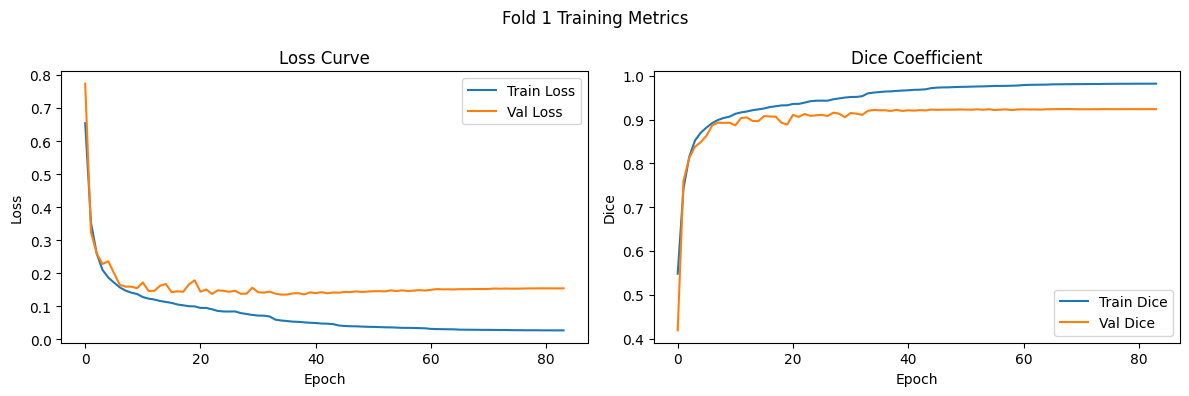

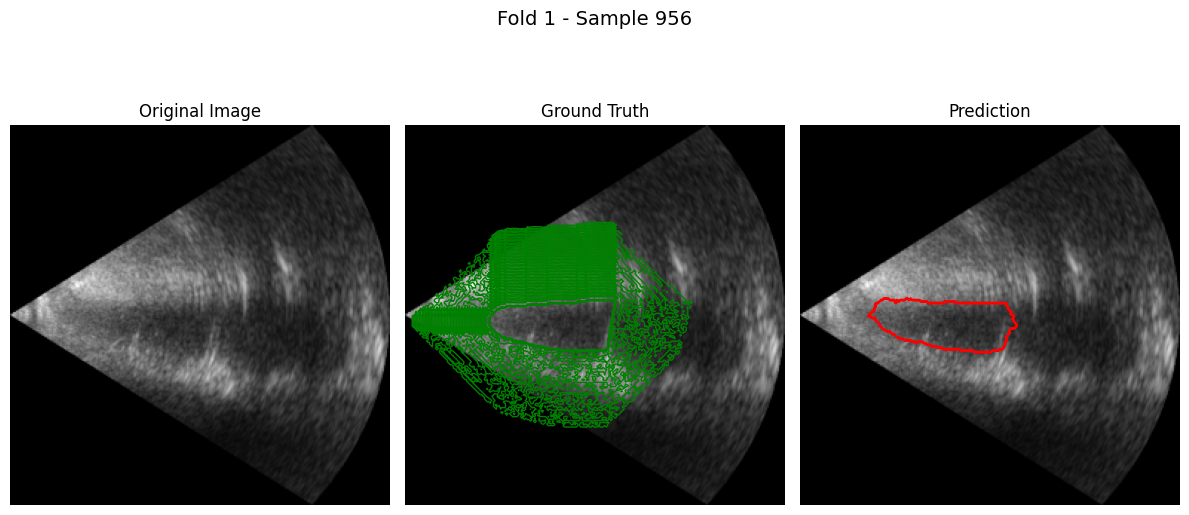


Fold 1 Validation Metrics:
Dice Coefficient: 0.9270
IoU: 0.8640

=== Fold 2/3 ===
Training on 4533 samples, validating on 2267 samples
Epoch 1/100
567/567 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.6183 - dice_coef: 0.4532 - iou_coef: 0.3046 - loss: 0.8428
Epoch 1: val_dice_coef improved from -inf to 0.59760, saving model to mamba_unet_fold1_best.keras
567/567 ━━━━━━━━━━━━━━━━━━━━ 258s 386ms/step - accuracy: 0.6184 - dice_coef: 0.4534 - iou_coef: 0.3048 - loss: 0.8424 - val_accuracy: 0.6473 - val_dice_coef: 0.5976 - val_iou_coef: 0.4334 - val_loss: 0.5388 - learning_rate: 1.0000e-04
Epoch 2/100
567/567 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.6590 - dice_coef: 0.7356 - iou_coef: 0.5837 - loss: 0.3650
Epoch 2: val_dice_coef improved from 0.59760 to 0.77170, saving model to mamba_unet_fold1_best.keras
567/567 ━━━━━━━━━━━━━━━━━━━━ 192s 339ms/step - accuracy: 0.6590 - dice_coef: 0.7357 - iou_coef: 0.5838 - loss: 0.3649 - val_accuracy: 0.6596 - val_dice_coef: 0.7717 - val_iou

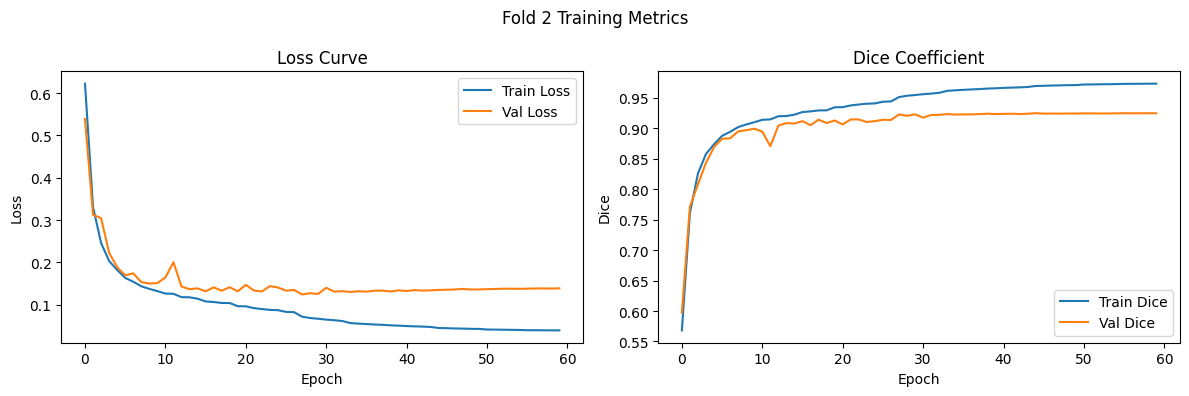

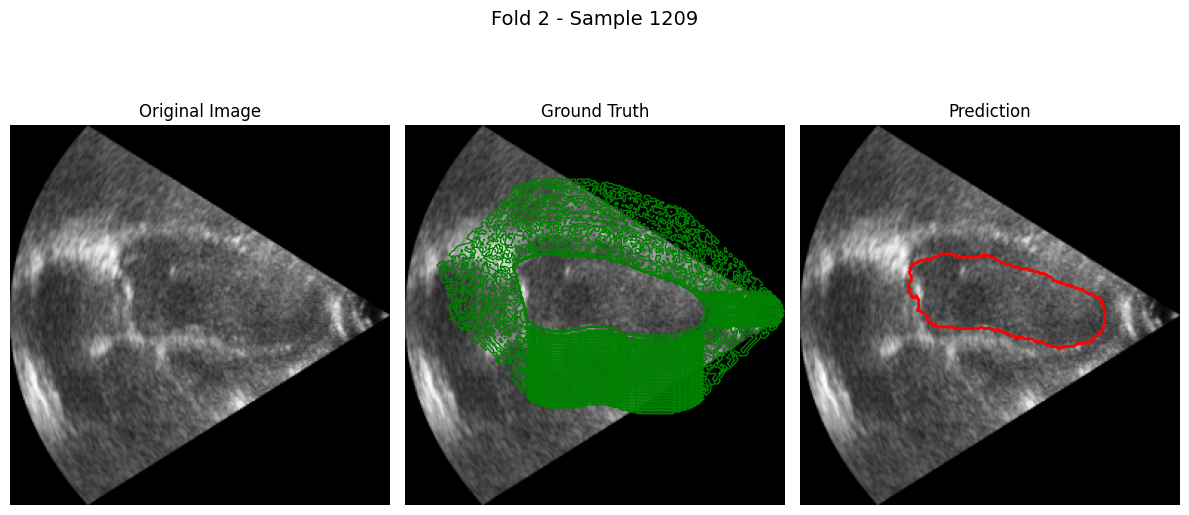


Fold 2 Validation Metrics:
Dice Coefficient: 0.9288
IoU: 0.8671

=== Fold 3/3 ===
Training on 4534 samples, validating on 2266 samples
Epoch 1/100
567/567 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.6241 - dice_coef: 0.4663 - iou_coef: 0.3167 - loss: 0.8082
Epoch 1: val_dice_coef improved from -inf to 0.66357, saving model to mamba_unet_fold2_best.keras
567/567 ━━━━━━━━━━━━━━━━━━━━ 276s 416ms/step - accuracy: 0.6242 - dice_coef: 0.4665 - iou_coef: 0.3168 - loss: 0.8078 - val_accuracy: 0.6570 - val_dice_coef: 0.6636 - val_iou_coef: 0.5016 - val_loss: 0.4512 - learning_rate: 1.0000e-04
Epoch 2/100
567/567 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.6605 - dice_coef: 0.7426 - iou_coef: 0.5927 - loss: 0.3569
Epoch 2: val_dice_coef improved from 0.66357 to 0.79200, saving model to mamba_unet_fold2_best.keras
567/567 ━━━━━━━━━━━━━━━━━━━━ 192s 339ms/step - accuracy: 0.6605 - dice_coef: 0.7426 - iou_coef: 0.5928 - loss: 0.3568 - val_accuracy: 0.6617 - val_dice_coef: 0.7920 - val_iou

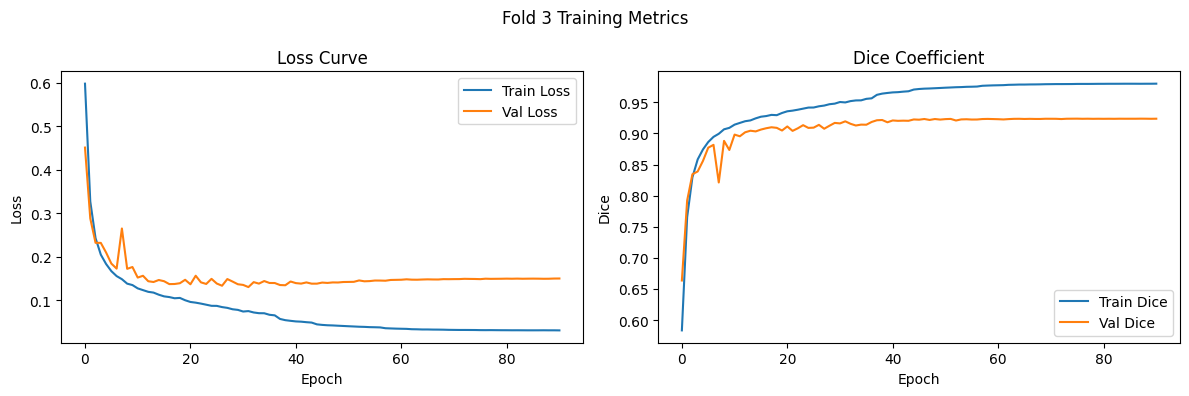

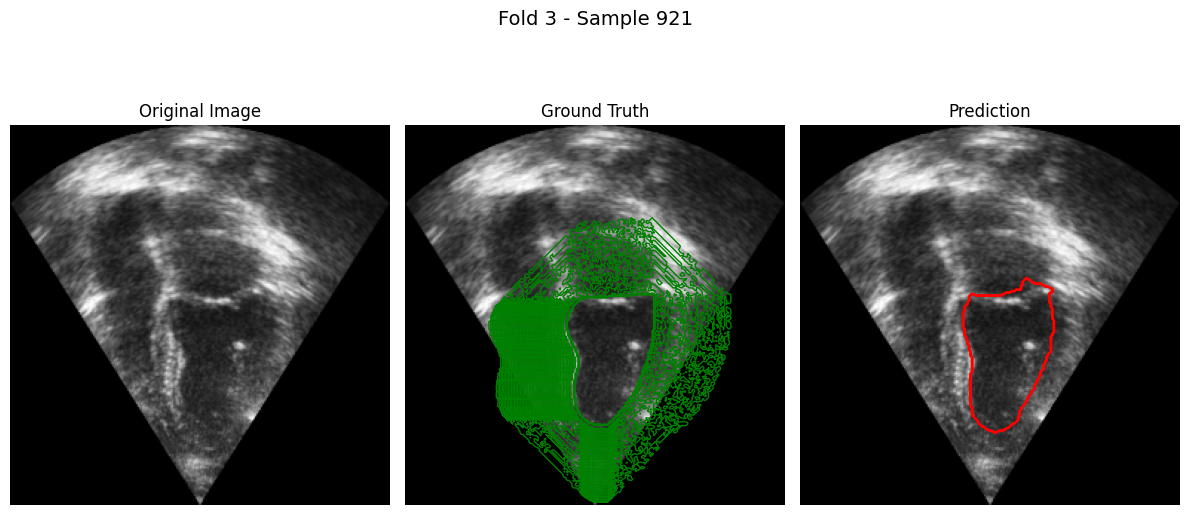


Fold 3 Validation Metrics:
Dice Coefficient: 0.9271
IoU: 0.8642

=== Final Evaluation on Test Set ===
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 289ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 163ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step

Ensemble Test Metrics:
Dice Coefficient: 0.9304
IoU: 0.8698


TypeError: can only concatenate str (not "int") to str

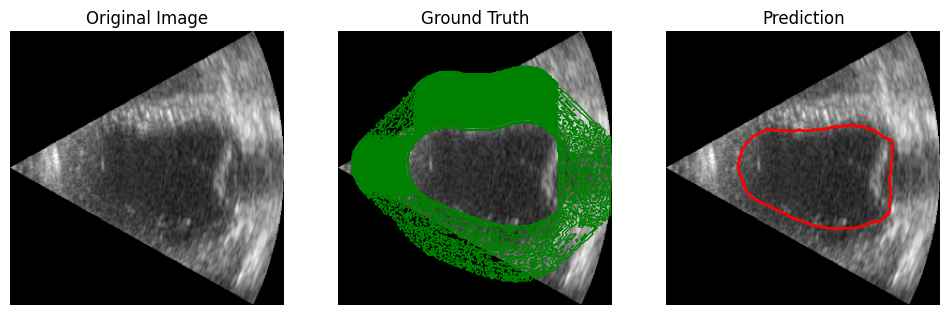

In [ ]:
if __name__ == '__main__':
    main()